## 前言
有時候線上申請一些服務時需要上傳文件, 例如註冊 Wemo 或是 GoShare 帳號需要上傳身分證跟機車駕照。如果拍照時太隨性不小心讓照片有點歪, 想用opencv練習去背以及轉正文件。

以[下圖](https://www.gmanetwork.com/news/news/nation/628549/lto-opens-backlog-printing-sites-to-hasten-3-6-m-pending-licenses/story/)為例練習 
<img src="./res/test5.jpg" alt="drawing" width="500"/>

### 1. 讀取圖片
用`cv2.imread` 讀取要處理的照片, 會儲存成 NumPy ndarray, 包含 height, width , channel (RGB維度) 三個維度

In [1]:
import cv2
import imutils
import numpy as np
import math
import matplotlib.pyplot as plt

img_default = cv2.imread('./res/test5.jpg', cv2.IMREAD_COLOR)
img_unchanged = cv2.imread('./res/test5.jpg', cv2.IMREAD_UNCHANGED)
img_grayscale = cv2.imread('./res/test5.jpg',2) #以灰階讀取圖片

print("type(img_unchanged) = ", type(img_unchanged))
print("img_grayscale.shape = ", img_grayscale.shape)

f = plt.figure(figsize=(20,5))
plt.subplot(1,3,1),plt.imshow(cv2.cvtColor(img_default, cv2.COLOR_BGR2RGB))
plt.title('Default')
plt.subplot(1,3,2),plt.imshow(cv2.cvtColor(img_unchanged, cv2.COLOR_BGR2RGB))
plt.title('Color Unchanged')
plt.subplot(1,3,3),plt.imshow(cv2.cvtColor(img_grayscale, cv2.COLOR_BGR2RGB))
plt.title('Gray Scale')
plt.show()


type(img_unchanged) =  <class 'numpy.ndarray'>
img_grayscale.shape =  (479, 640)


<Figure size 2000x500 with 3 Axes>

## Preprocess
這個階段透過opencv處理圖片，找出目標物的輪廓線

93 lines are detected


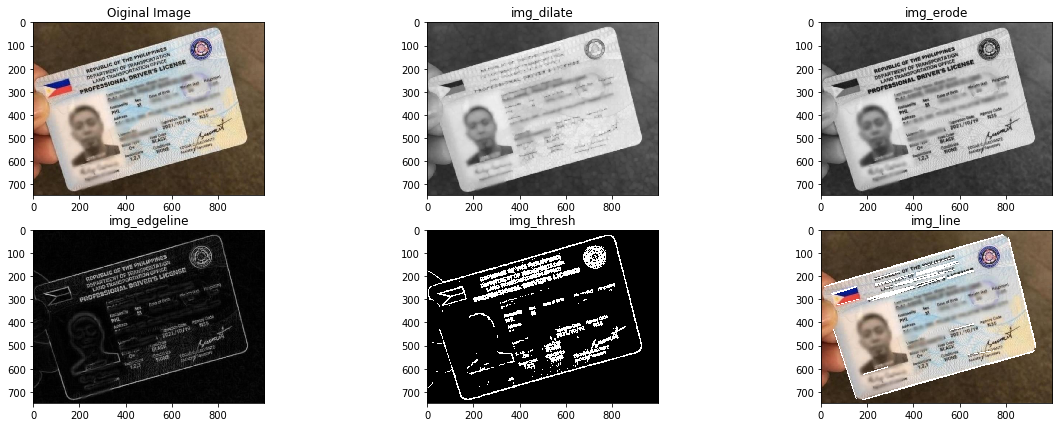

In [2]:
# Resize 圖片
image = imutils.resize(img_default, width=1000)

# 將圖片轉成灰階
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## https://www.itread01.com/content/1542925873.html
## 建構 N×N 的元素, 數字越大, 影像細節保留越多 
element = cv2.getStructuringElement(cv2.MORPH_RECT,(7, 7))
# cv2.dilate 擴大白色區域
img_dilate = cv2.dilate(img_gray, element) 

cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
# erode 縮小白色區域
img_erode = cv2.erode(img_gray, cross) 

## 把上面dilate與erode圖像相減可以得到輪廓線
img_edgeline = cv2.absdiff(img_dilate, img_erode) 

## 得到的輪廓線是灰階圖, 用 cv2.threshold 轉成 binary
_, img_thresh = cv2.threshold(img_edgeline, 40, 255, cv2.THRESH_BINARY)

## cv2.HoughLinesP 找出圖片裡 點跟點距離 < maxLineGap, 連起來長度 > minLineLength的所有直線
lines = cv2.HoughLinesP(img_thresh, 1, math.pi /180.0, 100, minLineLength= 100, maxLineGap=3)
img_line = image.copy()
for i in range(len(lines)):
    x1 = lines[i][0][0]
    y1 = lines[i][0][1]    
    x2 = lines[i][0][2]
    y2 = lines[i][0][3]
    cv2.line(img_line, (x1, y1), (x2, y2),(255,255,255), 2) # 用紅色畫出偵測到的直線
    # cv2.line是直接在圖片上畫出直線, 原始圖會被修改，所以用複製原始圖後的圖畫線, 避免動到原圖
print(len(lines) , "lines are detected")

f = plt.figure(figsize=(20,7))
plt.subplot(2,3,1),plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Oiginal Image')
plt.subplot(2,3,2),plt.imshow(cv2.cvtColor(img_dilate, cv2.COLOR_BGR2RGB))
plt.title('img_dilate')
plt.subplot(2,3,3),plt.imshow(cv2.cvtColor(img_erode, cv2.COLOR_BGR2RGB))
plt.title('img_erode')
plt.subplot(2,3,4),plt.imshow(cv2.cvtColor(img_edgeline, cv2.COLOR_BGR2RGB))
plt.title('img_edgeline')
plt.subplot(2,3,5),plt.imshow(cv2.cvtColor(img_thresh, cv2.COLOR_BGR2RGB))
plt.title('img_thresh')
plt.subplot(2,3,6),plt.imshow(cv2.cvtColor(img_line, cv2.COLOR_BGR2RGB))
plt.title('img_line')
plt.show()


Reference:
https://blog.gtwang.org/programming/opencv-basic-image-read-and-write-tutorial/

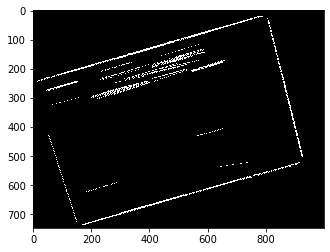

In [17]:
# 將偵測到的HoughLinesP畫在全黑的圖上
h , w , _ = image.shape
blank_image = np.zeros((h,w,1), np.uint8)

img_test = blank_image.copy()
for i in range(len(lines)):
    x1 = lines[i][0][0]
    y1 = lines[i][0][1]    
    x2 = lines[i][0][2]
    y2 = lines[i][0][3]
    cv2.line(img_test, (x1, y1), (x2, y2),(255,255,255), 1) # 用紅色畫出偵測到的直線

plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.show()

rect =  ((473.3359069824219, 379.62994384765625), (836.7214965820312, 525.46875), -15.871177673339844)


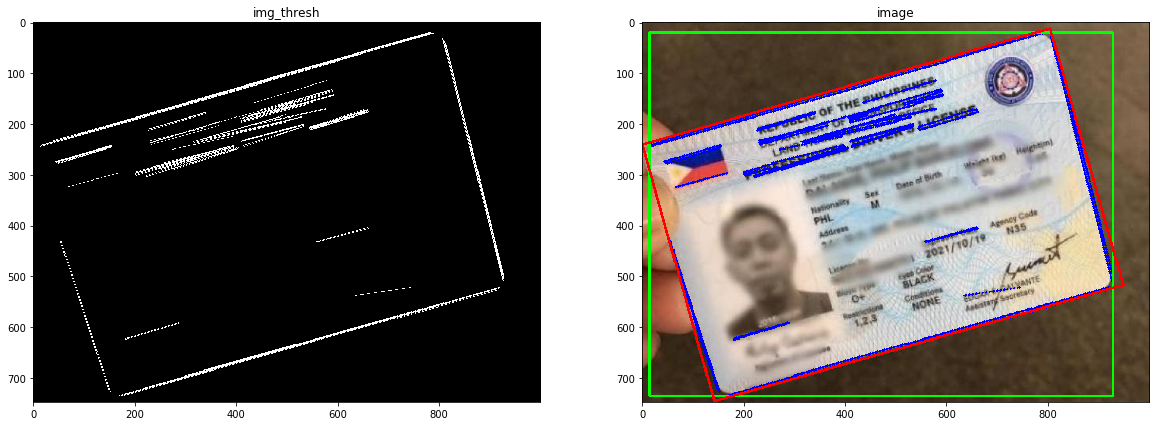

In [7]:
# Python 使用 OpenCV 自動裁切掃描文件白邊、修正傾斜角度教學
# https://blog.gtwang.org/programming/python-opencv-auto-crop-and-rotate-scanned-image-tutorial/

_, img_thresh = cv2.threshold(img_test, 40, 255, cv2.THRESH_BINARY)

# 產生等高線
contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 去除等高線層級, 拉出所有的contours
all_points = []
xy_list = []
for i in range(0, len(contours)):
    cnt = contours[i].shape[0]
    
    for j in range(0,cnt):
        xy_list.append(contours[i][j][0])
        
for x,y in xy_list:
    all_points.append([(x,y)])

cnts = np.asarray(all_points, dtype=int)
        

img_contours = image.copy()

# 以藍色線條畫出所有的等高線
cv2.drawContours(image, cnts, -1, (255, 0, 0), 3)

# 找出面積最大的等高線區域
c = max(contours, key = cv2.contourArea)

# 找出可以包住面積最大等高線區域的方框，並以綠色線條畫出來
x, y, w, h = cv2.boundingRect(cnts)
cv2.rectangle(img_contours,(x, y), (x + w, y + h), (0, 255, 0), 3)

# 嘗試在各種角度，以最小的方框包住面積最大的等高線區域，以紅色線條標示
rect = cv2.minAreaRect(cnts)
print("rect = ", rect)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img_contours, [box], 0, (0, 0, 255), 3)

f = plt.figure(figsize=(20,7))
plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(img_thresh, cv2.COLOR_BGR2RGB))
plt.title('img_thresh')
plt.subplot(1,2,2),plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
plt.title('image')

plt.show()


[[   0.961879     -0.27347539  121.34029336]
 [   0.27347539    0.961879   -122.48043926]]


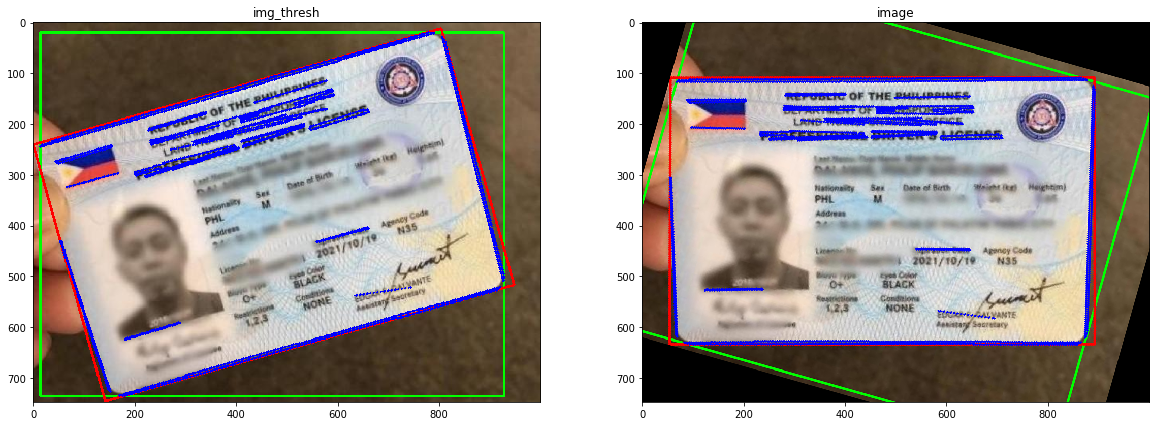

In [16]:
# 傾斜修正
# 取得紅色方框的旋轉角度
angle = rect[2]
if angle < -45:
  angle = 90 + angle

# 以影像中心為旋轉軸心
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

# 計算旋轉矩陣
M = cv2.getRotationMatrix2D(center, angle, 1.0)

# 旋轉圖片
rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)

f = plt.figure(figsize=(20,7))
plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('img_thresh')
plt.subplot(1,2,2),plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
plt.title('image')

plt.show()

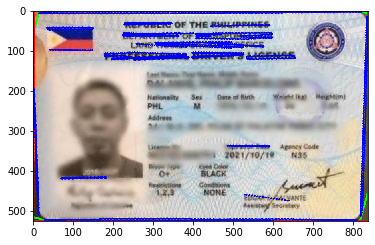

In [19]:
# 裁切邊緣影像
# 旋轉紅色方框座標
pts = np.int0(cv2.transform(np.array([box]), M))[0]

# 計算旋轉後的紅色方框範圍
y_min = min(pts[0][0], pts[1][0], pts[2][0], pts[3][0])
y_max = max(pts[0][0], pts[1][0], pts[2][0], pts[3][0])
x_min = min(pts[0][1], pts[1][1], pts[2][1], pts[3][1])
x_max = max(pts[0][1], pts[1][1], pts[2][1], pts[3][1])

# 裁切影像
img_crop = rotated[x_min:x_max, y_min:y_max]

# 除錯用的圖形
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
plt.show()